<a href="https://colab.research.google.com/github/9502357102/sales-demand-forecasting-using--ML/blob/main/Sales_and_demand_forecasting_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1}
MAE: 698787.860714286
RMSE: 827907.0278434512
Accuracy: 98.50%


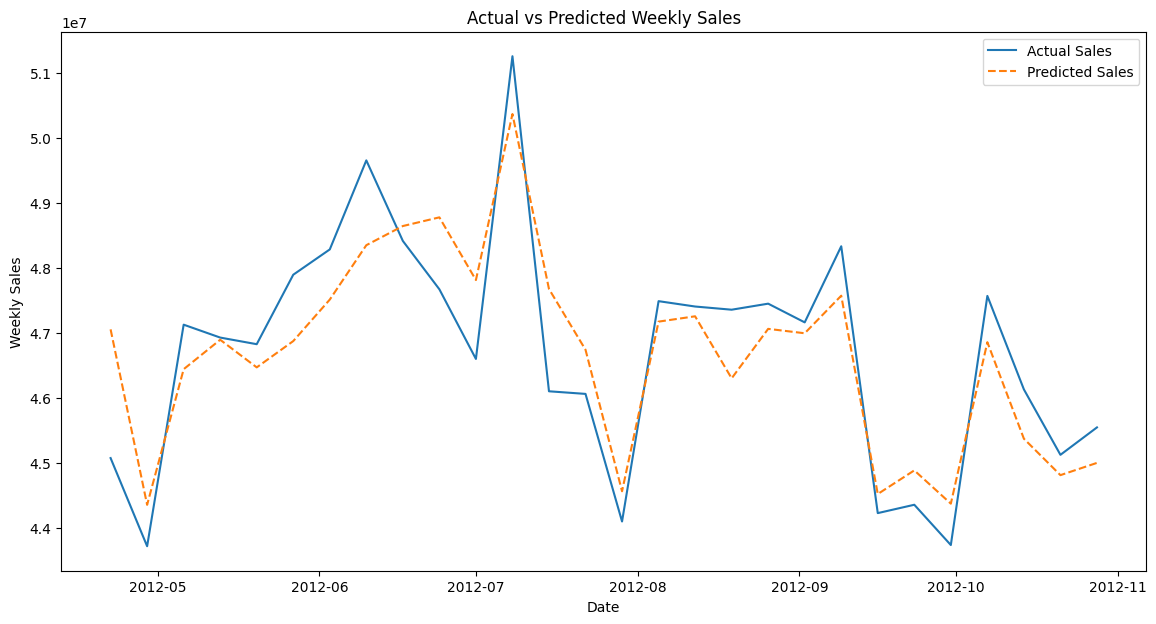

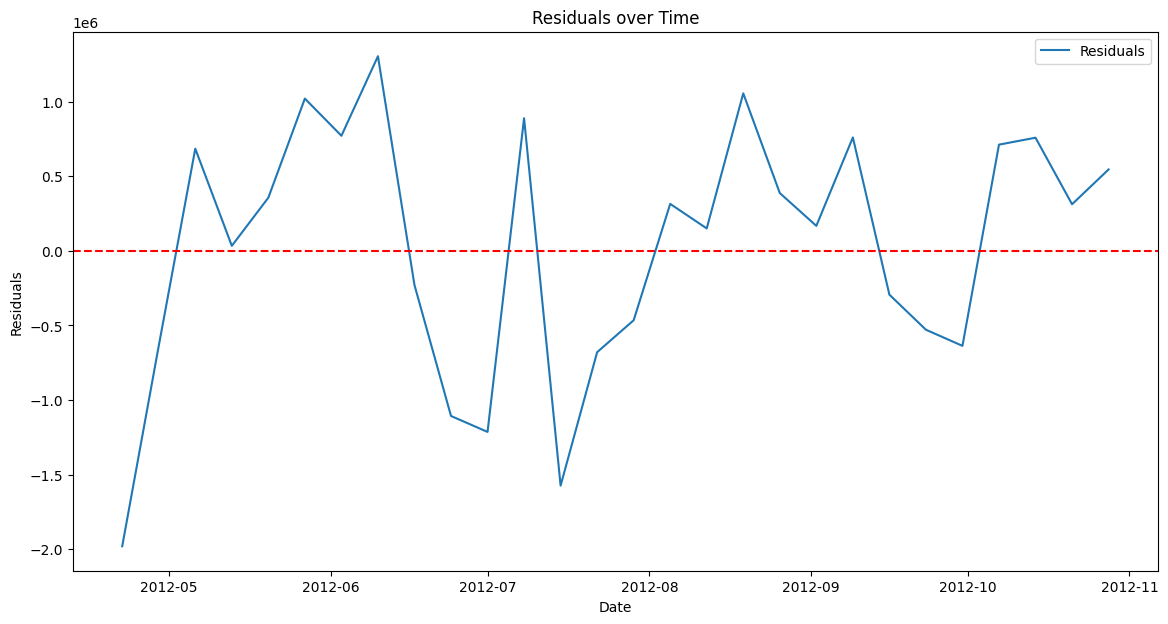

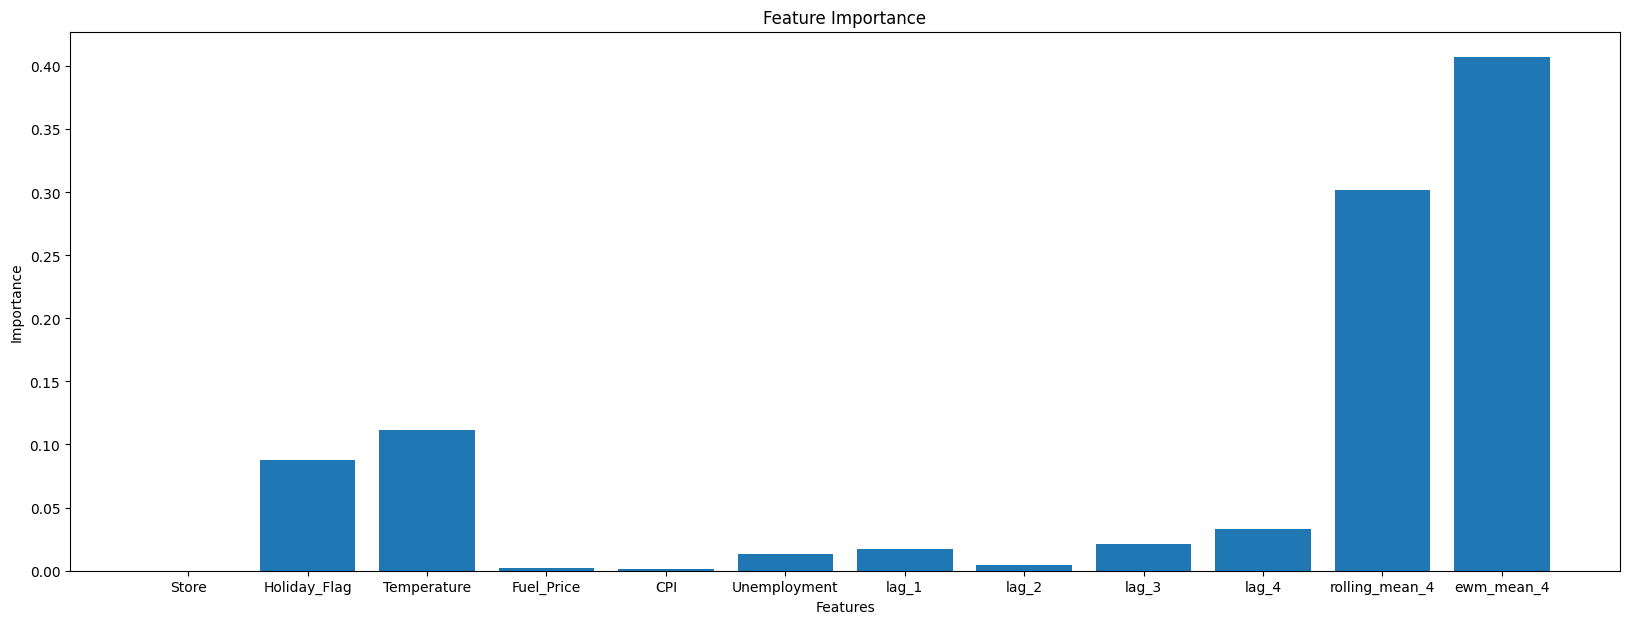

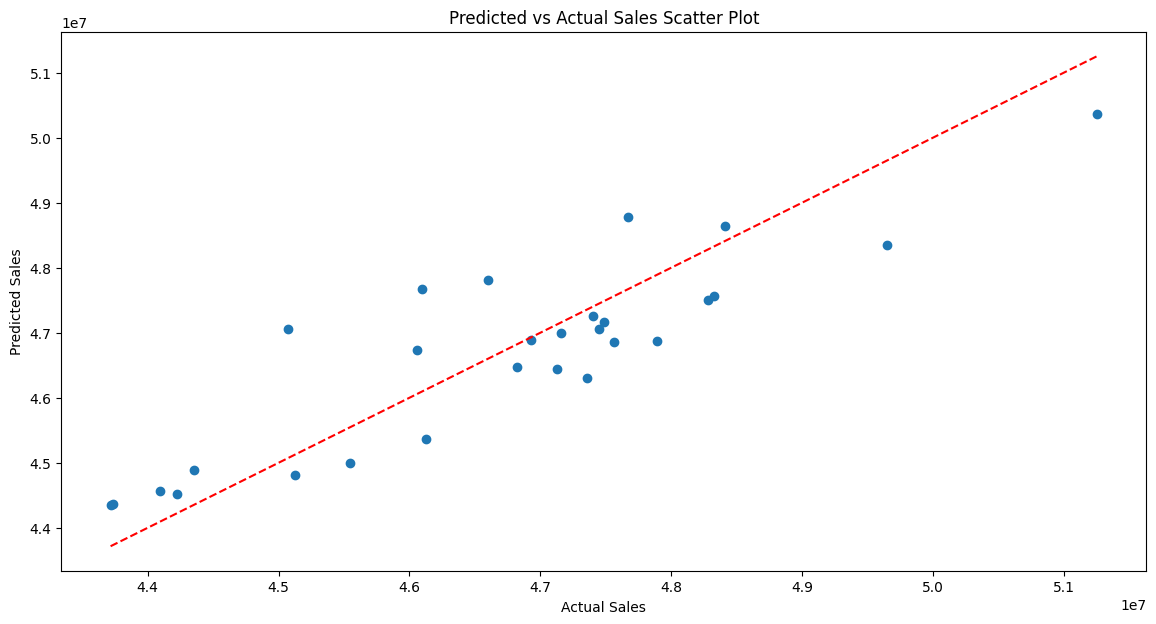

In [1]:
# Import the packages
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = '/content/walmart.csv'
df = pd.read_csv(file_path)

# Preprocessing
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)
weekly_sales = df.resample('W').sum()

for lag in range(1, 5):
    weekly_sales[f'lag_{lag}'] = weekly_sales['Weekly_Sales'].shift(lag)

weekly_sales['rolling_mean_4'] = weekly_sales['Weekly_Sales'].rolling(window=4).mean()
weekly_sales['ewm_mean_4'] = weekly_sales['Weekly_Sales'].ewm(span=4).mean()

weekly_sales.dropna(inplace=True)

# Training and Testing
train_size = int(len(weekly_sales) * 0.8)
train, test = weekly_sales[:train_size], weekly_sales[train_size:]

X_train, y_train = train.drop(columns=['Weekly_Sales']), train['Weekly_Sales']
X_test, y_test = test.drop(columns=['Weekly_Sales']), test['Weekly_Sales']

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
}

# Building of model
model = XGBRegressor()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

# Performance metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
accuracy = 100 - (mae / y_test.mean()) * 100
print(f'Best Parameters: {grid_search.best_params_}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'Accuracy: {accuracy:.2f}%')

# Plotting actual vs predicted sales
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label='Actual Sales')
plt.plot(test.index, predictions, label='Predicted Sales', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Actual vs Predicted Weekly Sales')
plt.legend()
plt.show()

# Plotting residuals
residuals = y_test - predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals over Time')
plt.legend()
plt.show()

# Plotting feature importance
importance = best_model.feature_importances_
plt.figure(figsize=(20, 7))
plt.bar(X_train.columns, importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# Plotting predictions vs actuals scatter plot
plt.figure(figsize=(14, 7))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Predicted vs Actual Sales Scatter Plot')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.show()


